In [7]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('tal'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [8]:
#libraries for CNN architecture
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [9]:
#path of dataset where all 5 classes data will be placed within there corresponding directories
image_set =  "talha/lung_colon_image_set/lung_image_sets"

In [10]:
#resize all images to 224,224 height and width
SIZE_X = SIZE_Y = 224

#data generator to load data in a efficient manner like batches of 128 images.
datagen = tf.keras.preprocessing.image.ImageDataGenerator(validation_split = 0.2)

#train data batches 128 images
train_set = datagen.flow_from_directory(image_set,
                                       class_mode = "categorical",
                                       target_size = (SIZE_X,SIZE_Y),
                                       color_mode="rgb",
                                       batch_size = 128, 
                                       shuffle = False,
                                       subset='training',
                                       seed = 42)
#test data batches of 128 images
validate_set = datagen.flow_from_directory(image_set,
                                       class_mode = "categorical",
                                       target_size = (SIZE_X, SIZE_Y),
                                       color_mode="rgb",
                                       batch_size = 128, 
                                       shuffle = False,
                                       subset='validation',
                                       seed = 42)

Found 20000 images belonging to 5 classes.
Found 5000 images belonging to 5 classes.


In [11]:
IMAGE_SIZE = [224, 224]

In [12]:
#loading pretrained resnet CNN model from keras models
resnet = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

/home/onstak/.local/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [24]:
#freezing all CNN layers to use as a feature extractor 
for layer in resnet.layers:
    layer.trainable = False

In [13]:
#adding custom ANN classifier to 
flatten = Flatten()(resnet.output)
dense = Dense(256, activation = 'relu')(flatten)
dense = Dense(128, activation = 'relu')(dense)
prediction = Dense(5, activation = 'softmax')(dense)
#creating a model
model = Model(inputs = resnet.input, outputs = prediction )
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0

In [14]:
#place it1_pretrained_model.h5 in current working directory it will load weights of CNN model and will use as fine tuning model perameters
model.load_weights('it1_pretrained_model.h5')

In [15]:
#compile model with loss and optimizer
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [ ]:
#executing the model
history = model.fit_generator(train_set, validation_data = (validate_set), epochs = 10, verbose = 1)

Epoch 1/10
 24/157 [===>..........................] - ETA: 56:04 - loss: 3.6799 - acc: 0.2819

In [ ]:
#saving model weights so that we can use it later for testing purposes in real world
model.save_weights('it2_pretrained_model.h5')

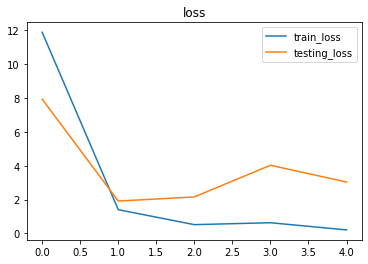

In [13]:
# plotting the loss
plt.plot(history.history['loss'],label = 'train_loss')
plt.plot(history.history['val_loss'], label = 'testing_loss')
plt.title('loss')
plt.legend()
plt.show()

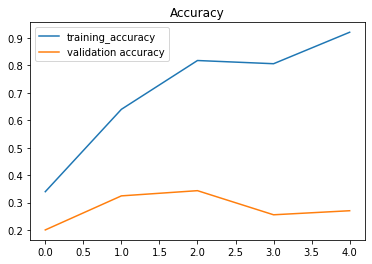

In [23]:
plt.plot(history.history['acc'], label='training_accuracy')
plt.plot(history.history['val_acc'], label='validation accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

In [21]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
Y_pred = model.predict_generator(validate_set)
y_pred = np.argmax(Y_pred ,axis =1)
print('Confusion Matrix')
confusion_matrix = confusion_matrix(validate_set.classes, y_pred)
print(confusion_matrix)
print('Classification Report')
print(classification_report(validate_set.classes, y_pred))

Confusion Matrix
[[769   3   0   0 228]
 [681 240   0   0  79]
 [798  10   2   5 185]
 [882 106   0  12   0]
 [670   2   1   0 327]]
Classification Report
              precision    recall  f1-score   support

           0       0.20      0.77      0.32      1000
           1       0.66      0.24      0.35      1000
           2       0.67      0.00      0.00      1000
           3       0.71      0.01      0.02      1000
           4       0.40      0.33      0.36      1000

    accuracy                           0.27      5000
   macro avg       0.53      0.27      0.21      5000
weighted avg       0.53      0.27      0.21      5000



In [22]:
result = model.evaluate(validate_set,batch_size=128)
print("test_loss, test accuracy",result)

40/40 [==============================] - 86s 2s/step - loss: 3.0351 - acc: 0.2700
test_loss, test accuracy [3.035135233402252, 0.27]
